In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from tqdm import tqdm

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, BatchNormalization

In [ ]:
from keras.datasets import mnist

In [ ]:
(X,_),(_,_) = mnist.load_data()

In [ ]:
X.shape

(60000, 28, 28)

In [ ]:
28 * 28

784

In [ ]:
X = X.reshape(60_000,784)

In [ ]:
discriminator = Sequential()
discriminator.add(Dense(input_dim=784,units=256,activation='relu'))

discriminator.add(Dense(units=64,activation='relu'))
discriminator.add(Dense(units=24,activation='relu'))
discriminator.add(Dense(units=64,activation='relu'))
discriminator.add(Dense(units=1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer='adam')

discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 64)                1600      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 220633 (861.85 KB)
Trainable params: 220633 (861.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
noise_dim = 100

In [ ]:
generator = Sequential()

generator.add(Dense(units=128,activation='relu',input_dim=noise_dim))
generator.add(BatchNormalization())

generator.add(Dense(units=256,activation='relu'))
generator.add(BatchNormalization())

generator.add(Dense(units=512,activation='relu'))
generator.add(BatchNormalization())

generator.add(Dense(units=784,activation='relu'))

generator.compile(loss='mae',optimizer='adam')

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               12928     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_2 (Bat  (None, 512)              

In [ ]:
discriminator.trainable = False   # weight Freezing

gan_input = generator.input

gen_output = generator(gan_input)
dis_output = discriminator(gen_output)

gan = Model(inputs=gan_input,outputs=dis_output)

gan.compile(loss='binary_crossentropy',optimizer='adam')

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5_input (InputLayer)  [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 784)               583312    
                                                                 
 sequential (Sequential)     (None, 1)                 220633    
                                                                 
Total params: 803945 (3.07 MB)
Trainable params: 581520 (2.22 MB)
Non-trainable params: 222425 (868.85 KB)
_________________________________________________________________


In [ ]:
  losses = {
      'D':[],
      'G':[]
  }

In [ ]:
def plot_loss(losses):
    d_loss = losses['D']
    g_loss =  losses['G']

    plt.figure(figsize=(10,8))
    plt.plot(d_loss,label='Discriminator Loss',c='g')
    plt.plot(g_loss,label='Generator Loss',c='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10,dim=(1,10),figsize=(12,2)):
    noise = np.random.normal(0,1,size=(n_ex,noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n_ex,28,28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
      plt.subplot(dim[0],dim[1],i+1)
      plt.imshow(generated_images[i],cmap='gray_r')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 2s 2s/step


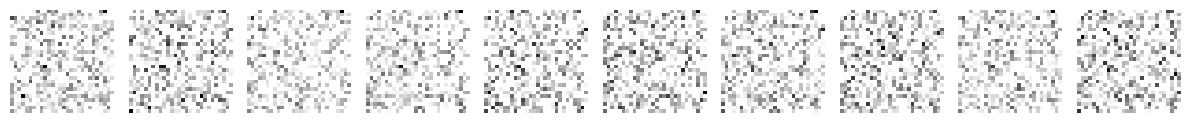

In [ ]:
plot_generated()

In [ ]:
def fit(epochs=20, plot_interval=5, batch_size=512):
    no_of_batches = X.shape[0] // 512
    for i in tqdm(range(1, epochs+1), desc='Training Progress'):
        print(f'------------- Epoch {i} -------------')
        for j in range(no_of_batches):
            # Taking Real Images
            batch_images = X[np.random.randint(0, 60_000, size=batch_size)]

            # Taking Fake Images (images from geneator)
            random_noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            generated_image = generator.predict(random_noise, verbose=0)

            # preparing datset with half fake and half real images
            X_train = np.concatenate((batch_images, generated_image))
            y_train = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))

            # Training Discriminator only
            discriminator.trainable = True
            dis_loss = discriminator.train_on_batch(X_train, y_train)

            # Training Generator only (GAN)
            discriminator.trainable = False
            X_gan = np.random.normal(0, 1, size=(batch_size*2, noise_dim))
            y_gan = np.ones(batch_size*2)
            gan_loss = gan.train_on_batch(X_gan, y_gan)
        losses['D'].append(dis_loss)
        losses['G'].append(gan_loss)
        if i == 1 or i%5 == 0:
            plot_generated()

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

------------- Epoch 1 -------------
1/1 [==============================] - 0s 21ms/step


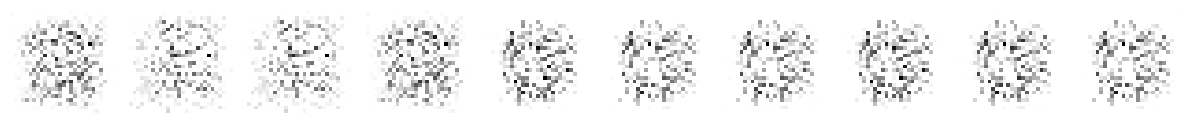

Training Progress:   5%|▌         | 1/20 [00:30<09:38, 30.46s/it]

------------- Epoch 2 -------------


Training Progress:  10%|█         | 2/20 [00:45<06:22, 21.25s/it]

------------- Epoch 3 -------------


Training Progress:  15%|█▌        | 3/20 [00:59<05:10, 18.27s/it]

------------- Epoch 4 -------------


Training Progress:  20%|██        | 4/20 [01:14<04:29, 16.86s/it]

------------- Epoch 5 -------------
1/1 [==============================] - 0s 18ms/step


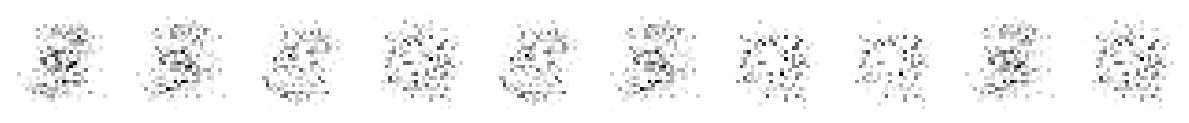

Training Progress:  25%|██▌       | 5/20 [01:29<04:03, 16.22s/it]

------------- Epoch 6 -------------


Training Progress:  30%|███       | 6/20 [01:44<03:40, 15.74s/it]

------------- Epoch 7 -------------


Training Progress:  35%|███▌      | 7/20 [01:59<03:21, 15.49s/it]

------------- Epoch 8 -------------


Training Progress:  40%|████      | 8/20 [02:15<03:08, 15.75s/it]

------------- Epoch 9 -------------


Training Progress:  45%|████▌     | 9/20 [02:30<02:49, 15.38s/it]

------------- Epoch 10 -------------
1/1 [==============================] - 0s 17ms/step


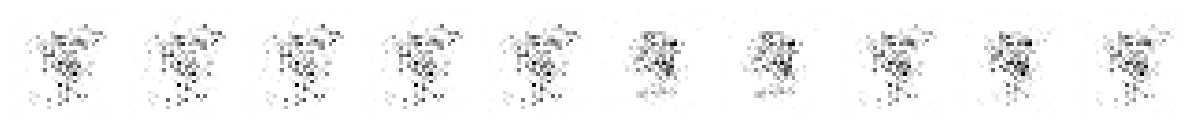

Training Progress:  50%|█████     | 10/20 [02:45<02:33, 15.32s/it]

------------- Epoch 11 -------------


Training Progress:  55%|█████▌    | 11/20 [03:00<02:16, 15.17s/it]

------------- Epoch 12 -------------


Training Progress:  60%|██████    | 12/20 [03:15<02:00, 15.02s/it]

------------- Epoch 13 -------------


Training Progress:  65%|██████▌   | 13/20 [03:30<01:45, 15.11s/it]

------------- Epoch 14 -------------


Training Progress:  70%|███████   | 14/20 [03:45<01:30, 15.16s/it]

------------- Epoch 15 -------------
1/1 [==============================] - 0s 23ms/step


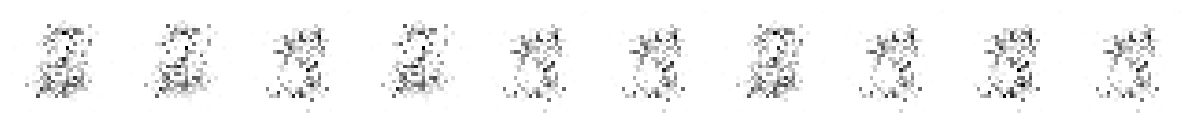

Training Progress:  75%|███████▌  | 15/20 [04:01<01:16, 15.25s/it]

------------- Epoch 16 -------------


Training Progress:  80%|████████  | 16/20 [04:16<01:01, 15.28s/it]

------------- Epoch 17 -------------


Training Progress:  85%|████████▌ | 17/20 [04:31<00:45, 15.14s/it]

------------- Epoch 18 -------------


Training Progress:  90%|█████████ | 18/20 [04:45<00:29, 14.98s/it]

------------- Epoch 19 -------------


Training Progress:  95%|█████████▌| 19/20 [05:00<00:14, 14.90s/it]

------------- Epoch 20 -------------
1/1 [==============================] - 0s 29ms/step


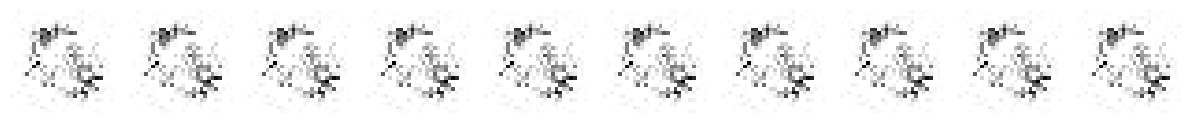

Training Progress: 100%|██████████| 20/20 [05:16<00:00, 15.82s/it]


In [ ]:
fit()